In [1]:
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.io as pio
import mne
import json
import glob
import os
from tqdm import tqdm
import time
from datetime import timedelta
from braindecode.datasets import BaseConcatDataset
from mne_features.feature_extraction import FeatureExtractor
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
from pyriemann.utils.distance import distance_riemann, distance_euclid, distance_logeuclid
from pyriemann.utils.mean import mean_riemann, mean_euclid, mean_logeuclid
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment, self_subject_label_alignment, relabel_dataset
from collections import defaultdict
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore') 

/home/administrator/.local/lib/python3.8/site-packages/mne_features/mock_numba.py:12: UserWarning: Numba needs NumPy 1.20 or less. Your code will be slower.
  warn('{}. Your code will be slower.'.format(err))


In [2]:
%%time
# fmt: off
subjects = [
    'K001', 'K002', 'K003', 'K004', 'K005', 
    'K006', 'K007', 'K008', 'K009', 'K010', 
    'K011', 'K012', 'K013', 'K015', 'K016', 
    'K017', 'K018', 'K021', 'K022', 'K023', 
    'K024', 'K025', 'K026', 'K027', 'K028', 
    'K300', 'K301', 'K302', 'K303', 'K304', 
    'K305', 'K306', 'K307', 'K308', 'K309', 
    'K310', 'K311', 'K312', 'K313', 'K314', 
    'K315', 'K316', 'K319', 'K320', 'K321', 
    'K322', 'K323', 'K324', 'K325', 'K326', 
    'K327', 'K328', 'K329', 'K330', 'K331', 
    'K332', 'K333', 'K334', 'K335', 'K336', 
    'K337', 'K338', 'K339', 'K342', 'K343', 
    'K344', 'K350', 'K351', 'K352', 'K353', 
    'K354', 'K355', 'K357', 'K358', 'K359', 
    'K360', 'K361', 'K362', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    "gật đầu",
    "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    # "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
    # "O1", "Oz", "O2",
]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    # "nâng chân trái_Thinking": "nâng chân trái",
    # "nâng chân phải_Thinking": "nâng chân phải",
    "nâng chân trái_Thinking": "nâng chân",
    "nâng chân phải_Thinking": "nâng chân",
    # "gật đầu_Thinking": "gật đầu",
    # "lắc đầu_Thinking": "lắc đầu",
    "gật đầu_Thinking": "gật/lắc đầu",
    "lắc đầu_Thinking": "gật/lắc đầu",
    "há miệng_Thinking": "há miệng",
    "nâng tay trái_Thinking and Acting": "nâng tay trái",
    "nâng tay phải_Thinking and Acting": "nâng tay phải",
    "nâng chân trái_Thinking and Acting": "nâng chân trái",
    "nâng chân phải_Thinking and Acting": "nâng chân phải",
    "gật đầu_Thinking and Acting": "gật đầu",
    "lắc đầu_Thinking and Acting": "lắc đầu",
    "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

max_duration = {  # seconds
    # "nâng tay trái": 10,
    # "nâng tay phải": 10,
    # "nâng chân trái": 10,
    # "nâng chân phải": 10,
    # "gật đầu": 10,
    # "lắc đầu": 10,
    # "rest": 10,
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

moving_standardize = False  # @param {"type": "boolean"}

ds = load_data(
    "../data/DataVIN/Official",  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    max_duration=max_duration,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=moving_standardize,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# als_subjects = [
#     'ALS01_t1', 'ALS01_t2', 'ALS01_t3', 'ALS01_t4', 'ALS01_t5', 'ALS01_t6',
#     'ALS02_t1', 'ALS02_t2', 'ALS02_t3', 'ALS02_t4', 
# ]

# als_ds = load_data(
#     "../data/DataVIN/ALS/als-patients",  
#     subjects=als_subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     max_duration=max_duration,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=moving_standardize,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# ds = als_ds
# subjects = als_subjects

# ds = BaseConcatDataset([ds, als_ds])
# subjects.extend(als_subjects)

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "ALS01_t2":
#         _ds_info["subject"] = "ALS01_t1"
#     elif _ds_info["subject"] == "ALS01_t4":
#         _ds_info["subject"] = "ALS01_t3"
#     elif _ds_info["subject"] == "ALS01_t6":
#         _ds_info["subject"] = "ALS01_t5"

# list_of_ds = list()
# for _ds in ds.datasets:
#     if _ds.description["label"] == "rest" and _ds.description["trial"] > 2:
#         continue
#     list_of_ds.append(_ds)
    
# ds = BaseConcatDataset(list_of_ds)
# del list_of_ds
        
ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 32 channels


trial: 100%|██████████| 3374/3374 [00:11<00:00, 286.11it/s]


loaded 90 subjects - 32489 epochs
CPU times: user 1min 19s, sys: 10.1 s, total: 1min 29s
Wall time: 1min 29s


,subject,scenario,event,onset,label,label_idx,trial,split,epochs
0,K001,nâng tay trái,Thinking,6.7125,nâng tay trái,4,0,train,9
1,K001,nâng tay trái,Resting,13.1479,rest,0,0,train,10
2,K001,nâng tay trái,Resting,32.7215,rest,0,1,train,5
3,K001,nâng tay trái,Thinking,37.0182,nâng tay trái,4,1,train,10
4,K001,nâng tay trái,Thinking,62.7771,nâng tay trái,4,2,train,10
...,...,...,...,...,...,...,...,...,...
3369,K375,lắc đầu,Thinking,6.0130,gật/lắc đầu,1,0,train,10
3370,K375,lắc đầu,Thinking,24.6901,gật/lắc đầu,1,1,train,9
3371,K375,lắc đầu,Resting,40.4353,rest,0,0,train,5
3372,K375,lắc đầu,Thinking,44.9166,gật/lắc đầu,1,2,train,10


5 classes
gật/lắc đầu: 4.5s-15.0s
nâng chân: 4.5s-15.5s
nâng tay phải: 5.0s-10.0s
nâng tay trái: 4.5s-15.0s
rest: 4.0s-17.0s


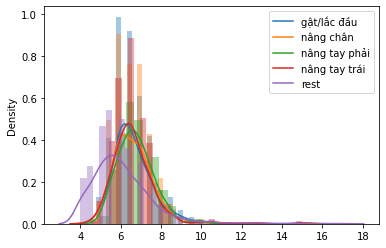

In [3]:
window_duration = 2.0  # @param
window_stride_duration = 0.5  # @param

labels = sorted(list(set(ds_info["label"])))
print(f"{len(labels)} classes")

for label in labels:
    du = list()
    for _, r in ds_info[ds_info["label"] == label].iterrows():
        du.append((r["epochs"] - 1) * window_stride_duration + window_duration)

    print(f"{label}: {min(du)}s-{max(du)}s")
    sb.distplot(du)

plt.legend(labels)

In [5]:
test_subjects = [
    'K309', 'K311', 'K312', 'K313', 'K315', 
    'K316', 'K321', 'K322', 'K323', 'K325', 
    'K327', 'K328', 'K332', 'K335', 'K336', 
    'K337', 'K339', 'K354', 'K358', 'K359', 
    'K360', 'K362', 'K365', 'K366', 'K368', 
    'K370', 'K372', 'K373', 'K374', 'K375',
]

### classify rest/gật-lắc đầu/nâng chân/nâng tay phải/nâng tay trái

In [ ]:
for i in range(0, len(test_subjects), 5):
    _test_subjects = test_subjects[i:i+5]
    print("=" * 80)
    print(f"testing on subjects: {_test_subjects}")
    print("=" * 80)
    
    # -----------load data--------------
    Xtrain = list()
    Ytrain = list()
    test_subject_data = defaultdict(list)
    for _ds in ds.datasets:
        if _ds.description["subject"] in _test_subjects:
            test_subject_data[_ds.description["subject"]].append(_ds)
        else:
            Xtrain.append(_ds.windows.get_data())
            Ytrain.extend(_ds.y)
            
    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.array(Ytrain, dtype=int)
    
    for subject, list_of_ds in test_subject_data.items():
        Xtest = list()
        Ytest = list()
        for _ds in list_of_ds:
            Xtest.append(_ds.windows.get_data())
            Ytest.extend(_ds.y)
            
        Xtest = np.concatenate(Xtest, axis=0)
        Ytest = np.array(Ytest, dtype=int)
        
        test_subject_data[subject] = (Xtest, Ytest)
        
    # ----------classification model-----
    csp = mne.decoding.CSP(n_components=32, reg=None, log=None, rank="full", transform_into='csp_space')
    Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
    
    for subject, (Xtest, Ytest) in test_subject_data.items():
        test_subject_data[subject] = (csp.transform(Xtest), Ytest)
    
    bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28,32)]
    params = dict({
        'pow_freq_bands__log': True,
        'pow_freq_bands__normalize': False,
        'pow_freq_bands__freq_bands': bands,
    })
    
    # ---------fitting-------------------
    max_nc = {k: 0 for k in test_subject_data.keys()}
    max_acc = {k: 0 for k in test_subject_data.keys()}
    max_cfm = {k: 0 for k in test_subject_data.keys()}
    for nc in tqdm(range(1, 33), desc="components"):
        fe = FeatureExtractor(sfreq=128.0, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

        clf = SVC(
            C=0.1,
            kernel="rbf",
            # tol=1e-7,
            max_iter=100000,
            class_weight="balanced",
            random_state=42,
        )
        
        clf.fit(fe.fit_transform(Xtrain_csp[:, :nc], Ytrain), Ytrain)
        
        # make prediction
        for subject, (Xtest_csp, Ytest) in test_subject_data.items():
            Ypred = clf.predict(fe.transform(Xtest_csp[:, :nc]))
            
            acc = metrics.balanced_accuracy_score(Ytest, Ypred)
            if acc >= max_acc[subject]:
                max_nc[subject] = nc
                max_acc[subject] = acc
                max_cfm[subject] = metrics.confusion_matrix(Ytest, Ypred)
                
    # ---------print result---------------
    for subject, acc in max_acc.items():
        print(f"subject {subject} - acc: {acc} ({max_nc[subject]} components)")
        print(max_cfm[subject])

testing on subjects: ['K309', 'K311', 'K312', 'K313', 'K315']


components: 100%|██████████| 32/32 [2:44:54<00:00, 309.20s/it]  


subject K309 - acc: 0.49198746338047794 (19 components)
[[295   3   9   3  33]
 [  1   7  40   2   8]
 [  0   0  49   0   8]
 [  0   0   5   1  24]
 [  0   1  11   0  17]]
subject K311 - acc: 0.7040570232170912 (24 components)
[[334   0   3   1   0]
 [  1  67   5   0   1]
 [  2  22  25   4  11]
 [  1   6  15  12   3]
 [  3   0   0   0  31]]
subject K312 - acc: 0.36904757085020246 (1 components)
[[318   0   0   7   0]
 [ 27   0   0  37   5]
 [ 18   0   0  44  10]
 [  9   0   0  27   2]
 [ 16   0   0  11   5]]
subject K313 - acc: 0.4155608821332294 (6 components)
[[130   0  10  80  91]
 [  0  28  26   9   0]
 [  0  21  26  27   1]
 [  3   1   9  26   5]
 [  0   0   6  20  10]]
subject K315 - acc: 0.4426343519494204 (3 components)
[[333   0   0   7  24]
 [  0   9  16  25  18]
 [  0   7  15  37  14]
 [  0   1  10  21   2]
 [  1   2   3  17  12]]
testing on subjects: ['K316', 'K321', 'K322', 'K323', 'K325']


components: 100%|██████████| 32/32 [2:51:10<00:00, 320.95s/it]  


subject K316 - acc: 0.4177199805542052 (16 components)
[[219  79  65   0   0]
 [  0  44  24   0   0]
 [  0  10  57   1   0]
 [  0  11  22   0   0]
 [  0   0  33   0   0]]
subject K321 - acc: 0.393452380952381 (24 components)
[[37  8  0  0  3]
 [ 0 47  0  0  9]
 [ 0 60  0  0  0]
 [ 0 27  0  0  1]
 [ 0 14  1  3 10]]
subject K322 - acc: 0.4447245564892624 (4 components)
[[105   6   1   1   6]
 [  0  14  20   2  13]
 [  0   4  23  10  17]
 [  0   0   9   5  13]
 [  0   0   0  15  12]]
subject K323 - acc: 0.4110466447448545 (26 components)
[[131   1  23   0   6]
 [  0   0  55   0   0]
 [  0   2  47   1   1]
 [  0   4  12   8   1]
 [  0   4  16   7   0]]
subject K325 - acc: 0.5167406253761888 (9 components)
[[57  0  0  0  7]
 [ 0 28 31  6  0]
 [ 0  9 52  9  1]
 [ 0  1 18  6  2]
 [ 0  0 10  8  8]]
testing on subjects: ['K327', 'K328', 'K332', 'K335', 'K336']


components:  81%|████████▏ | 26/32 [1:58:11<45:40, 456.67s/it]  

### classify rest/gật-lắc đầu/nâng chân/nâng tay phải/nâng tay trái (EA)